In [94]:

import statistics
import timeit
import itertools
import numpy as np
import torch
import torch.nn as nn
import optuna
import sklearn.metrics as skm
import torch
import importlib
import fastai
import tsai
import torch.nn.functional as F
import copy
import shap
importlib.reload(fastai)
importlib.reload(tsai)

from collections import Counter
from tsai.all import *
from tsai.data.validation import combine_split_data, get_splits
from tsai.models.InceptionTimePlus import InceptionTimePlus
from tsai.tslearner import TSClassifier
from optuna.samplers import TPESampler
from optuna.integration import FastAIPruningCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch.utils.data import WeightedRandomSampler
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau
from fastai.data.transforms import Categorize
from fastai.losses import BCEWithLogitsLossFlat, FocalLoss, FocalLossFlat
from fastai.metrics import accuracy, BrierScore, F1Score, RocAucBinary


import Data_load_neat as Data_load
import MLmodel_opt_learner_neat as MLmodel_opt_learner

In [95]:
# load in arguments from command line
name = "data_2real2bigdet"
model_name="InceptionTime"
randnum_split=3
epochs=8
device = 1
filepath="/home/DIDE/smishra/Simulations/"
folds=5

In [96]:

X_raw, y_raw = Data_load.load_data(name=name,filepath=filepath)

## Function to obtain the train/test split
X_trainvalid, Y_trainvalid, X_test, Y_test, splits = Data_load.split_data(X=X_raw,Y=y_raw,randnum=randnum_split)

## Now scale all the data for ease (can fix this later)
X_scaled=Data_load.prep_data(X_raw,splits)

X_trainvalid_s, X_test_s=X_scaled[splits[0]], X_scaled[splits[1]]


(100000, 9, 40) (100000, 40) (100000, 1)
(100000,)
Random state set:3, cuda used: True
Counter({0.0: 99399, 1.0: 601}) Counter({0.0: 79519, 1.0: 481}) Counter({0.0: 19880, 1.0: 120})
X_trainvalid: mean = 0.218; std = 0.413: min mean = 0.000: max mean = 0.611
1
X_test: mean = 0.219; std = 0.414: min mean = 0.003: max mean = 0.603
0
X_trainvalid_s: mean = 0.471; std = 0.555: min mean = 0.412: max mean = 0.529
0
X_test_s: mean = 0.471; std = 0.555: min mean = 0.412: max mean = 0.529
0
Y_trainvalid: mean = 0.006; std = 0.077
Y_test: mean = 0.006; std = 0.077


In [97]:
# Give the architecture for each model
if model_name=="LSTMFCN":
    arch=LSTM_FCNPlus

if model_name=="TCN":
    arch=TCN

if model_name=="XCM":
    arch=XCMPlus

if model_name=="ResCNN":
    arch=ResCNN

if model_name=="ResNet":
    arch=ResNetPlus

if model_name=="InceptionTime":
    arch=InceptionTimePlus

if model_name=="MLSTMFCN":
    arch=MLSTM_FCNPlus


## Set seed
Data_load.random_seed(randnum_split)
torch.set_num_threads(18)

## split out the test set
splits_9010 = get_splits(
        Y_trainvalid,
        valid_size=0.1,
        stratify=True,
        shuffle=True,
        test_size=0,
        show_plot=False,
        random_state=randnum_split
        )
Xtrainvalid90=X_trainvalid[splits_9010[0]]
Ytrainvalid90=Y_trainvalid[splits_9010[0]]
Xtrainvalid10=X_trainvalid[splits_9010[1]]
Ytrainvalid10=Y_trainvalid[splits_9010[1]]

randnum=1



Random state set:3, cuda used: True


In [98]:
def test_results(f_model,X_test,Y_test):

    valid_dl=f_model.dls.valid

    # obtain probability scores, predicted values and targets
    test_ds=valid_dl.dataset.add_test(X_test,Y_test)
    test_dl=valid_dl.new(test_ds)
    test_probas, test_targets,test_preds=f_model.get_preds(dl=test_dl,with_decoded=True,save_preds=None,save_targs=None)

    # get the min, max and median of probability scores for each class
    where1s=np.where(Y_test==1)
    where0s=np.where(Y_test==0)
    test_probasout=test_probas.numpy()
    test_probasout=test_probasout[:,1]
    print("Y equal 0:")
    print([min(test_probasout[where0s]),statistics.mean(test_probasout[where0s]),max(test_probasout[where0s])])
    print("Y equal 1:")
    print([min(test_probasout[where1s]),statistics.mean(test_probasout[where1s]),max(test_probasout[where1s])])

    ## get the various metrics for model fit
    acc=skm.accuracy_score(test_targets,test_preds)
    prec=skm.precision_score(test_targets,test_preds)
    rec=skm.recall_score(test_targets,test_preds)
    fone=skm.f1_score(test_targets,test_preds)
    auc=skm.roc_auc_score(test_targets,test_preds)
    prc=skm.average_precision_score(test_targets,test_preds)
    print(f"accuracy: {acc:.4f}")
    print(f"precision: {prec:.4f}")
    print(f"recall: {rec:.4f}")
    print(f"f1: {fone:.4f}")
    print(f"auc: {auc:.4f}")
    print(f"prc: {prc:.4f}")

    return acc, prec, rec, fone, auc, prc

TensorCategory(0.0156, device='cuda:1')
TensorCategory(0., device='cuda:1')
TensorCategory(0., device='cuda:1')
TensorCategory(0., device='cuda:1')
TensorCategory(0., device='cuda:1')
TensorCategory(0.0156, device='cuda:1')
TensorCategory(0., device='cuda:1')
TensorCategory(0., device='cuda:1')
TensorCategory(0.0156, device='cuda:1')
TensorCategory(0.0312, device='cuda:1')
2
40
9


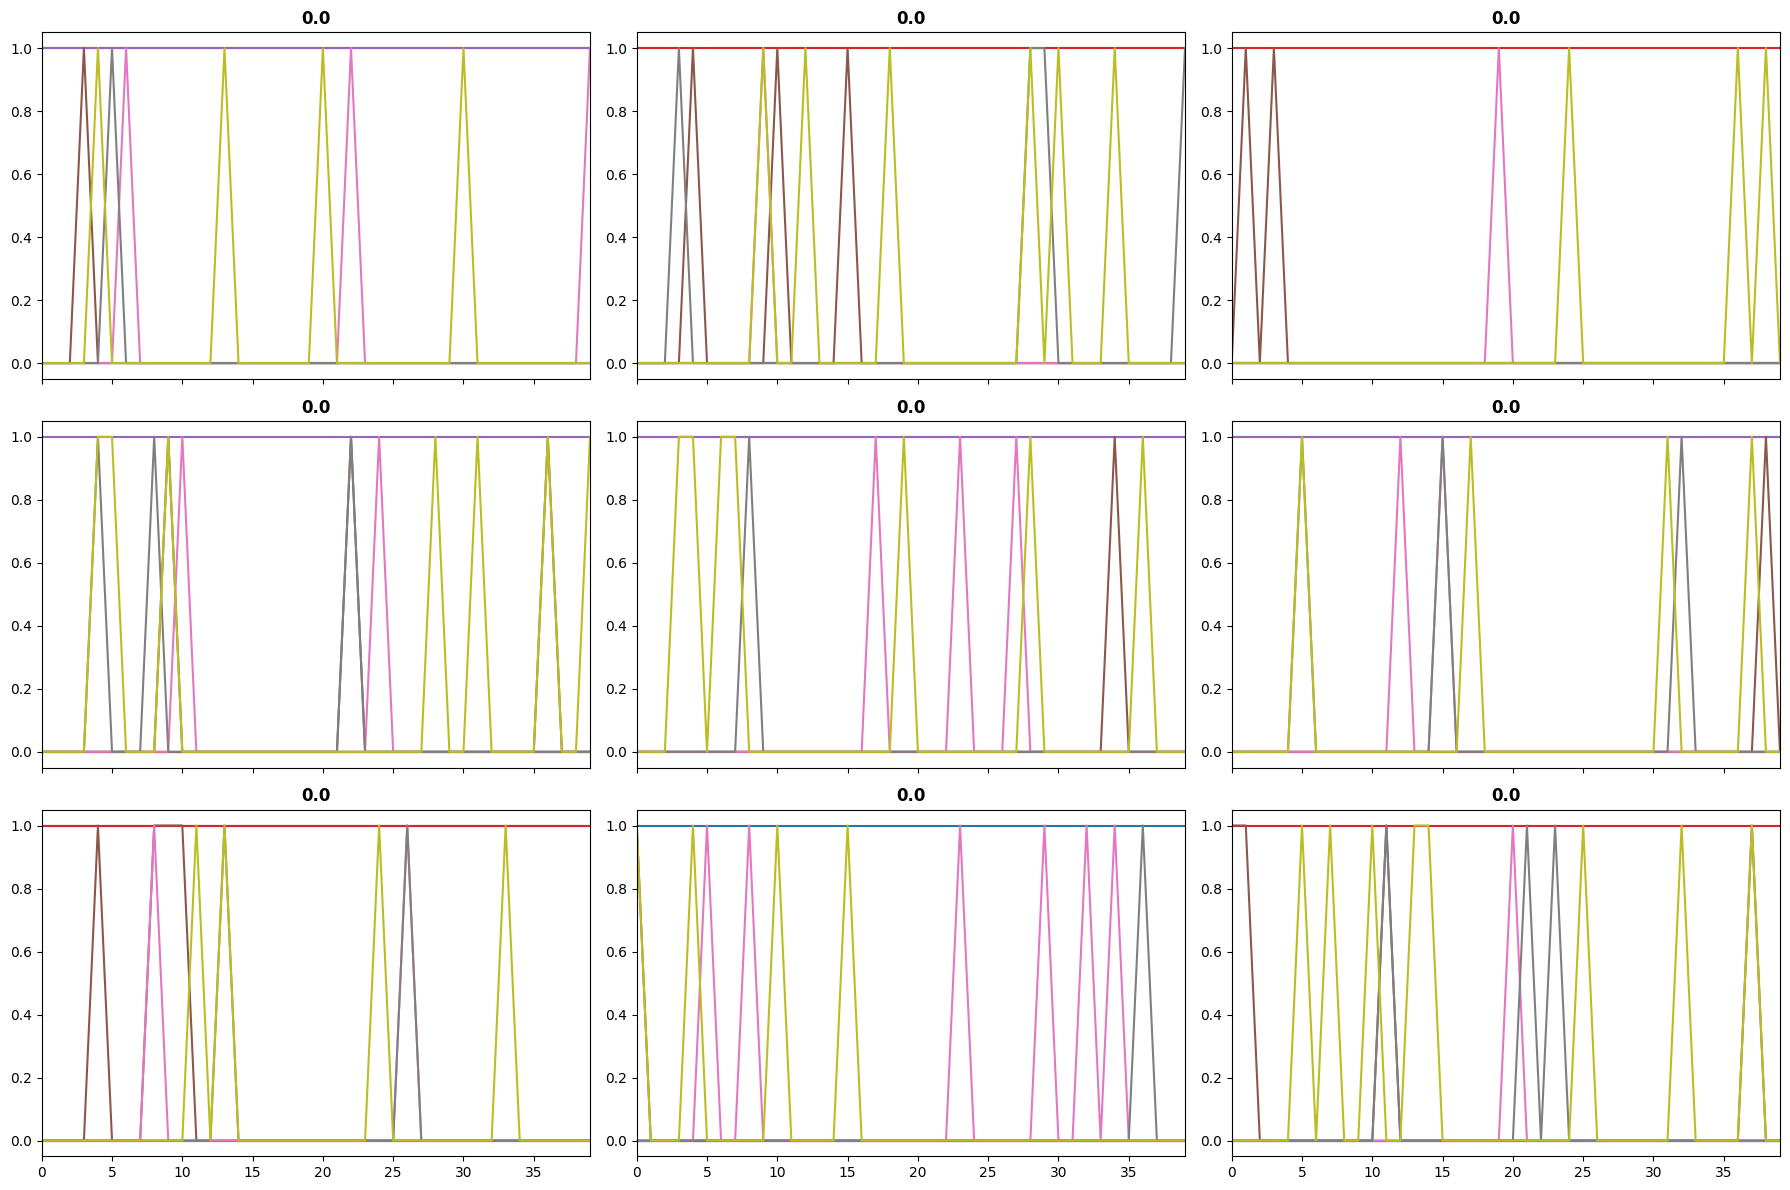

In [99]:

# loop for fitting model with generic/pre-specified hyperparameters
lr_max=1e-3
batch_size=64
alpha=0.5
gamma=3

colnames=["data","model","seed","epochs", "accuracy", "precision", "recall", "f1", "auc","prc", "time","lr_max","batch_size","alpha","gamma"]
output = pd.DataFrame(columns=colnames)

# Fitting the model on train/test with pre-selected hyperparameters
# define the metrics for model fitting output
metrics=[accuracy,F1Score(),RocAucBinary(),BrierScore()]
weights=torch.tensor([alpha,1-alpha], dtype=torch.float).to(device)

ESPatience=2

# prep the data for the model
tfms=[None,[Categorize()]]
dsets = TSDatasets(X_trainvalid, Y_trainvalid, tfms=tfms, splits=splits_9010,inplace=True)

dls=TSDataLoaders.from_dsets(
    dsets.train,
    dsets.valid,
    bs=batch_size,
    num_workers=0,
    device=device
    )

for i in range(10):
    x,y = dls.one_batch()
    print(sum(y)/len(y))

print(dls.c)
print(dls.len)
print(dls.vars)


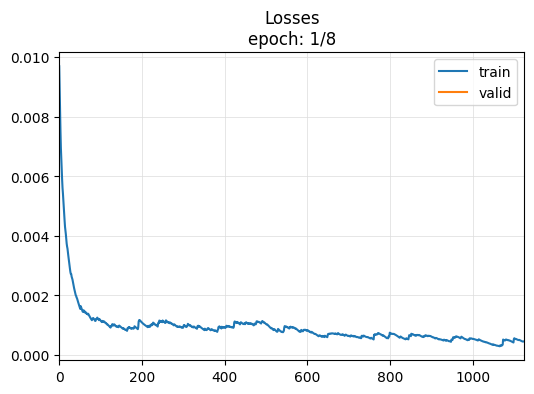

Epoch 6: reducing lr to 6.711302080890608e-06


Y equal 0:
[2.7428292e-05, 0.013158817, 0.89739555]
Y equal 1:
[0.6565314, 0.891144, 0.9621477]
accuracy: 0.9995
precision: 0.9231
recall: 1.0000
f1: 0.9600
auc: 0.9997
prc: 0.9231
Y 0, predicted 0 (true negatives)        19870.000000
Y 0, predicted 1 (false positives)       10.000000
Y 1, predicted 0 (false negatives)       0.000000
Y 1, predicted 1 (true positives)        120.000000
                data          model seed epochs trials  accuracy  precision  \
0  data_2real2bigdet  InceptionTime    1      8      5    0.9995   0.923077   

   recall    f1       auc       prc   LR00 LR01 LR10 LR11         time  \
0     1.0  0.96  0.999748  0.923077  19870   10    0  120  1016.412978   

   lr_max batch_size  alpha gamma  
0   0.001         64    0.5     3  


In [100]:
Data_load.random_seed2(randnum,dls=dls)
start=timeit.default_timer()

model = arch(dls.vars, dls.c)

model.to(device)

learn = Learner(
    dls, 
    model, 
    metrics=metrics,
    loss_func=FocalLossFlat(gamma=torch.tensor(gamma).to(device),weight=weights),
    cbs=[EarlyStoppingCallback(patience=ESPatience),ReduceLROnPlateau(),ShowGraph()]
    )

learn.fit_one_cycle(epochs, lr_max)

stop=timeit.default_timer()
runtime=stop-start

acc, prec, rec, fone, auc, prc=MLmodel_opt_learner.test_results(learn,X_test,Y_test)

# Formatting and saving the output
outputs=[name, model_name, randnum, epochs, acc, prec, rec, fone, auc,prc, runtime,lr_max,batch_size,alpha,gamma]
entry = pd.DataFrame([outputs], columns=colnames)
output = pd.concat([output, entry], ignore_index=True)
print(output)

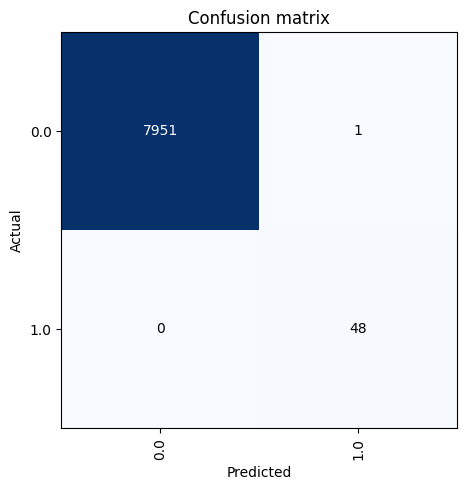

In [102]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [207]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = learn.model

    def forward(self, x):
        output = self.model(x).softmax(-1) # something like this
        test_out=output[:, -1]
        test_new=test_out.reshape([output.shape[0],1])
        return torch.tensor(test_new)#output[:, -1] # if it doesn't work it's output[:,-1]

module = MyModel()

In [200]:
batch = dls.one_batch()
num_samples = 100

explainer = shap.DeepExplainer(
    module, torch.tensor(batch[0][:num_samples])
)

# calculate shapely values
shap_values = explainer.shap_values(
    torch.tensor(batch[0][num_samples:])
)
print(shap_values)

torch.Size([64, 2])
64
torch.Size([64])
torch.Size([64, 1])
[]


In [197]:
module(torch.tensor(batch[0][:num_samples]))

torch.Size([64, 2])
64
torch.Size([64])
torch.Size([64, 1])


tensor([[0.0207],
        [0.0113],
        [0.0022],
        [0.0025],
        [0.0183],
        [0.0069],
        [0.0052],
        [0.0065],
        [0.0099],
        [0.0105],
        [0.0078],
        [0.0066],
        [0.0124],
        [0.0133],
        [0.0025],
        [0.0077],
        [0.0123],
        [0.0076],
        [0.0231],
        [0.0071],
        [0.0182],
        [0.0279],
        [0.0218],
        [0.0026],
        [0.0076],
        [0.0026],
        [0.0127],
        [0.0041],
        [0.0283],
        [0.0029],
        [0.0043],
        [0.0108],
        [0.0151],
        [0.0170],
        [0.0107],
        [0.0154],
        [0.0186],
        [0.0040],
        [0.0054],
        [0.0054],
        [0.0009],
        [0.0035],
        [0.0237],
        [0.0017],
        [0.0017],
        [0.0056],
        [0.0062],
        [0.0040],
        [0.0037],
        [0.0212],
        [0.0052],
        [0.0349],
        [0.0176],
        [0.0120],
        [0.0264],
        [0

In [124]:
torch.Tensor(batch[0][:num_samples])

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [ ]:

## The code below gives you Flatten and the double Adaptive Pooling (from fastai), plus
## a viable head. Mind that you got to fill the number of FC's nodes manually
from torch import Tensor
from torch import nn
import logging as log
from typing import Optional # required for "Optional[type]"

class Flatten(nn.Module):
    "Flatten `x` to a single dimension, often used at the end of a model. `full` for rank-1 tensor"
    def __init__(self, full:bool=False):
        super().__init__()
        self.full = full

    def forward(self, x):
        return x.view(-1) if self.full else x.view(x.size(0), -1)

class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`." # from pytorch
    def __init__(self, sz:Optional[int]=None): 
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    
def myhead(nf, nc):
    return \
    nn.Sequential(        # the dropout is needed otherwise you cannot load the weights
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.BatchNorm1d(nf),
            nn.Dropout(p=0.375),
            nn.Linear(nf, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.75),
            nn.Linear(512, nc),
        )


import torch
import torchvision

my_model=torchvision.models.resnet101() 
modules=list(my_model.children())
modules.pop(-1) 
modules.pop(-1) 
temp=nn.Sequential(nn.Sequential(*modules))
tempchildren=list(temp.children()) 
tempchildren.append(myhead(4096,2))
my_r101=nn.Sequential(*tempchildren)


torch.save({'state_dict': learner_name.model.state_dict()}, '/path/name.pth').

model=my_r101
weighties = torch.load('/path/name.pth')
model.load_state_dict(weighties['state_dict'])

from PIL import Image
import torchvision.transforms.functional as TTF
import torch
import numpy as np

img = '/your/image.jpg'
softmaxer = torch.nn.Softmax(dim=1)
model.eval()
image = Image.open(img)
x = TTF.to_tensor(image)
x.unsqueeze_(0)
print(x.shape)
raw_out = model(x)
out = softmaxer(raw_out)
print(out[0])



In [205]:
learn.export('myModelSHAP.pkl')

TypeError: cannot pickle 'code' object

In [203]:
import torch
import torchvision
import torchvision.transforms as transforms
from fastai.vision.all import *

# load FastAI ResNet model
learn = load_learner('models/myModelSHAP.pkl')

# get PyTorch model
# .model attribute stores the model
# .eval() sets the model into evaluation mode - no backward propagation
pytorch_model = learn.model.eval()

# define softmax layer
softmax_layer = torch.nn.Softmax(dim=1) # define softmax

# define normalization layer
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406, 0.406, 0.406, 0.406, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225])

# assemble the final model
final_model = nn.Sequential(
    normalization_layer,
    pytorch_model,
    softmax_layer
)

RuntimeError: PytorchStreamReader failed locating file data.pkl: file not found

In [43]:
from TSInterpret.InterpretabilityModels.Saliency.TSR import TSR
int_mod=TSR(learn, X_trainvalid.shape[-2],X_trainvalid.shape[-1], method='IG',mode='time')
item= np.array([X_test[0,:,:]])
label=int(np.argmax(y_test[0]))

exp=int_mod.explain(item,labels=label,TSR =True)

%matplotlib inline  
int_mod.plot(np.array([X_test[0,:,:]]),exp)

NotImplementedError: Please use a TF or PYT Classification model!                 If the current model is a TF or PYT Model,                 try calling the wrappers directly                 (TF -> Saliency_TF, PYT -> Saliency_PYT)

In [202]:
get_attribution_map(learn, learn,X_trainvalid)


get_acts_and_grads(learn, learn, X_trainvalid)



TypeError: conv1d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
